In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
# Optional for clear plotting on Macs
%config InlineBackend.figure_format = 'retina'


In [2]:
# Read files resulting from the previous pre-processing step
X_train = np.loadtxt("X_train.txt")
x_train_wo_evi = X_train[:, :48]
y_train = np.loadtxt('y_train.txt')

X_val = np.loadtxt("X_val.txt")
x_val_wo_evi = X_val[:, :48]
y_val = np.loadtxt('y_val.txt')

X_test = np.loadtxt("X_test.txt")
x_test_wo_evi = X_test[:, :48]
y_test = np.loadtxt('y_test.txt')


# For RandomSeachCV, we will need to combine training and validation
# sets then specify which portion is training and which is validation
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
x_train_plus_val_wo_evi = X_train_plus_val[:, :48]
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV
validation_fold = np.concatenate(
    (-1 * np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)


### PART I. Default RANDOM FOREST Model using Normalized Features with and without EVI

In [38]:
# 1A
# Run DEFAULT RANDOM FOREST WITH ALL BANDS but no EVI three times
# to get the Average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_1 = []
r_2_lst_1 = []

for i in range(3):
    rf_model_base = RandomForestRegressor(
        random_state=i).fit(x_train_wo_evi, y_train)
    rmse_lst_1.append(
        np.sqrt(mse(y_test, rf_model_base.predict(x_test_wo_evi))))
    r_2_lst_1.append(rf_model_base.score(x_test_wo_evi, y_test))

# calculate standard deviation of RMSE
std_1 = np.std(rmse_lst_1)
print(f"""
RMSEs on Test Dataset: {rmse_lst_1}
Average RMSE: {np.mean(rmse_lst_1):.4f}
Standard Deviation of RMSEs: {std_1:.4f}
R-Squared on Test Dataset: {r_2_lst_1}
Average R-Squared: {np.mean(r_2_lst_1):.2%}
""")



RMSEs on Test Dataset: [64.74199433350823, 64.53501151315295, 64.59867333792359]
Average RMSE: 64.6252
Standard Deviation of RMSEs: 0.0866
R-Squared on Test Dataset: [0.013334266735742784, 0.019633003865480392, 0.0176978454390605]
Average R-Squared: 1.69%



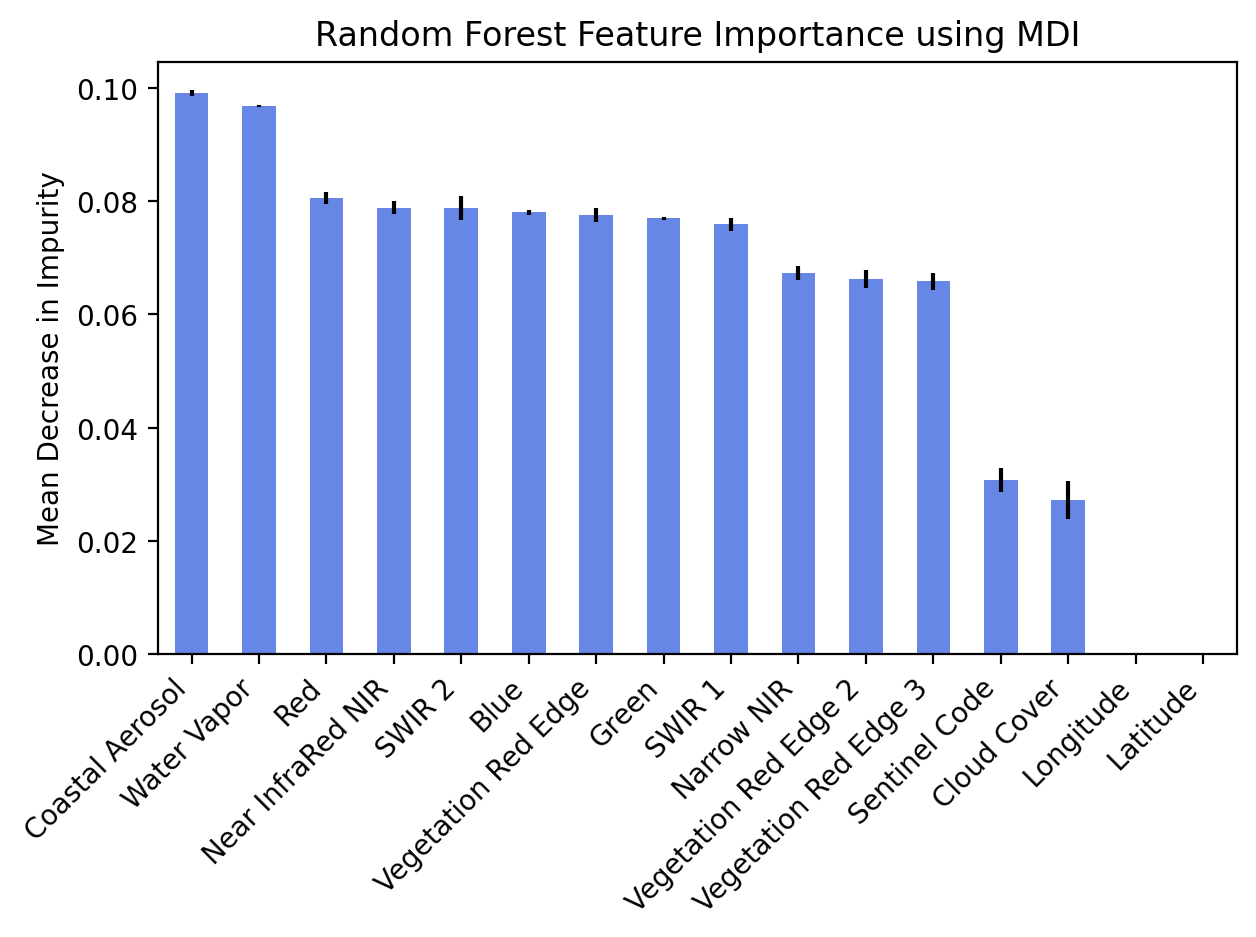

In [39]:
# Extract Feature Importance
importances_wo_evi = rf_model_base.feature_importances_.reshape(
    16, -1).sum(axis=1)
x_label_wo_evi = ["Coastal Aerosol", "Blue", "Green", "Red", "Vegetation Red Edge", "Vegetation Red Edge 2", "Vegetation Red Edge 3",
                  "Near InfraRed NIR", "Narrow NIR", "Water Vapor", "SWIR 1", "SWIR 2", "Cloud Cover", "Sentinel Code", "Latitude", "Longitude"]
std_wo_evi = rf_model_base.feature_importances_.reshape(16, -1).std(axis=1)


def sorted_bar_graph(values:np.ndarray, x_labels: list[str], std: np.ndarray, title: str, y_label: str)->None:
    """Plot sorted bar graph with standard deviation for Random Forest feature importance."""
    # create tuples of importance scores and labels, sort by importance scores
    sorted_data = sorted(
        zip(values, x_labels, std), reverse=True)

    # unpack sorted importance scores and labels into separate lists
    sorted_values, sorted_labels, sorted_std = zip(
        *sorted_data)

    fig, ax = plt.subplots()
    forest_importances = pd.Series(
        sorted_values, index=sorted_labels)
    forest_importances.plot.bar(yerr=sorted_std, ax=ax, color="royalblue", alpha=0.8)
    ax.set_title(title)
    ax.set_xticks(range(len(sorted_labels)),
                sorted_labels, rotation=45, ha="right")
    ax.set_ylabel(y_label)
    fig.tight_layout()
    plt.show()

sorted_bar_graph(importances_wo_evi, x_label_wo_evi, std_wo_evi, "Random Forest Feature Importance using MDI", "Mean Decrease in Impurity")

In [5]:
# 1B
# xgboost WITH ALL BANDS but no EVI
import xgboost as xgb
xgb_default = xgb.XGBRegressor()

xgb_default.fit(x_train_wo_evi, y_train)

print(f"""
Training MSE: {mse(y_train, xgb_default.predict(x_train_wo_evi))}
Training RMSE: {np.sqrt(mse(y_train, xgb_default.predict(x_train_wo_evi)))}
Validation MSE: {mse(y_val, xgb_default.predict(x_val_wo_evi))}
Validation RMSE: {np.sqrt(mse(y_val, xgb_default.predict(x_val_wo_evi)))}
Test MSE: {mse(y_test, xgb_default.predict(x_test_wo_evi))}
Test RMSE: {np.sqrt(mse(y_test, xgb_default.predict(x_test_wo_evi)))}
""")



Training MSE: 1455.4607637548763
Training RMSE: 38.15050148759353
Validation MSE: 4238.5450994967105
Validation RMSE: 65.10410969744315
Test MSE: 4340.534633390086
Test RMSE: 65.88273395503624



In [6]:
# 1C
# Run DEFAULT RANDOM FOREST WITH ALL BANDS including EVI three times
# to get the Average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_2 = []
r_2_lst_2 = []

for i in range(3):
    rf_model_evi = RandomForestRegressor(random_state=i).fit(X_train, y_train)
    rmse_lst_2.append(np.sqrt(mse(y_test, rf_model_evi.predict(X_test))))
    r_2_lst_2.append(rf_model_evi.score(X_test, y_test))

# calculate standard deviation of RMSE
std_2 = np.std(rmse_lst_2)
print(f"""
RMSEs on Test Dataset: {rmse_lst_2}
Average RMSE: {np.mean(rmse_lst_2):.4f}
Standard Deviation of RMSEs: {std_2:.4f}
R-Squared on Test Dataset: {r_2_lst_2}
Average R-Squared: {np.mean(r_2_lst_2):.2%}
""")



RMSEs on Test Dataset: [64.86969324605968, 64.67094636645264, 64.84354297860004]
Average RMSE: 64.7947
Standard Deviation of RMSEs: 0.0882
R-Squared on Test Dataset: [0.009438174203012184, 0.01549861557860488, 0.010236643697282388]
Average R-Squared: 1.17%



### II. FINE TUNING: RANDOM FOREST WITH ALL BANDS

In [7]:
# FINE TUNING on all normalized features
rf_model_ft_wo_evi = RandomForestRegressor(random_state=1)

# Define the hyperparameters to tune
max_depth_wo_evi = list(np.linspace(1, 10, 10, dtype=int))
max_depth_wo_evi.append(None)
hyperparameters_wo_evi = {
    "n_estimators": np.linspace(100, 120, 5, dtype=int),
    "max_depth": max_depth_wo_evi,
}

# Define the random search object
random_search_wo_evi = RandomizedSearchCV(
    estimator=rf_model_ft_wo_evi,
    param_distributions=hyperparameters_wo_evi,
    n_iter=55,
    cv=train_val_split,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search object to the training data
random_search_wo_evi.fit(x_train_plus_val_wo_evi, y_train_plus_val)
# summarize results
print(f"""Best Parameter for Model with original standardized features:\
{random_search_wo_evi.best_params_}.
""")


Best Parameter for Model with original standardized features:{'n_estimators': 115, 'max_depth': 5}.



In [8]:
# Run Fine Tuned RANDOM FOREST WITH ALL BANDS except EVI three times
# to get the Average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_3 = []
r_2_lst_3 = []

for i in range(3):
    rf_model_no_evi = RandomForestRegressor(
        **random_search_wo_evi.best_params_,
        random_state=i
    ).fit(x_train_wo_evi, y_train)
    rmse_lst_3.append(
        np.sqrt(mse(y_test, rf_model_no_evi.predict(x_test_wo_evi))))
    r_2_lst_3.append(rf_model_no_evi.score(x_test_wo_evi, y_test))

# calculate standard deviation of RMSE
std_3 = np.std(rmse_lst_3)
print(f"""
RMSEs on Test Dataset: {rmse_lst_3}
Average RMSE: {np.mean(rmse_lst_3):.4f}
Standard Deviation of RMSEs: {std_3:.4f}
R-Squared on Test Dataset: {r_2_lst_3}
Average R-Squared: {np.mean(r_2_lst_3):.2%}
""")



RMSEs on Test Dataset: [64.82693234830462, 64.82984799131695, 64.84388141672017]
Average RMSE: 64.8336
Standard Deviation of RMSEs: 0.0074
R-Squared on Test Dataset: [0.010743663723830621, 0.010654676536498209, 0.010226311919947384]
Average R-Squared: 1.05%



> Because the fine-tuned random forest trained using the original standardized features did not perform better than the random forest model with default parameters, the analysis will consider results from the default random forest model in PartI - 1A as the best performing model. 

In [40]:
# FINE TUNING on EVI bands
rf_model_ft = RandomForestRegressor(random_state=1)


max_depth = list(np.linspace(1, 10, 10, dtype=int))
max_depth.append(None)
# Define the hyperparameters to tune

hyperparameters = {
    "n_estimators": np.linspace(95, 105, 5, dtype=int),
    "max_depth": max_depth,
}

# Define the random search object
random_search = RandomizedSearchCV(
    estimator=rf_model_ft,
    param_distributions=hyperparameters,
    n_iter=55,
    cv=train_val_split,
    random_state=42,
    n_jobs=-1,
)

# Fit the random search object to the training data
random_search.fit(X_train_plus_val, y_train_plus_val)
# summarize results
print(f"""Best Parameter for Model with EVI feature:\
{random_search.best_params_}.
""")


Best Parameter for Model with EVI feature:{'n_estimators': 100, 'max_depth': 6}.



> Because the fine-tuned random forest trained using the standardized features and EVI performed better than the one trained with default paramaters (PartI - 1C), the analysis will consider the hyperparameter above the best paramters for the random forest trained with EVI feature engineering. Feature importance is calculated based on that. 

In [41]:
# Run Fined Tuned RANDOM FOREST WITH ALL BANDS and EVI three times
# to get the Average test RMSE and standard deviation of the RMSE for the default random forest model
rmse_lst_4 = []
r_2_lst_4 = []

for i in range(3):
    rf_model_evi = RandomForestRegressor(
        **random_search.best_params_,
        random_state=i).fit(X_train_plus_val, y_train_plus_val)
    rmse_lst_4.append(np.sqrt(mse(y_test, rf_model_evi.predict(X_test))))
    r_2_lst_4.append(rf_model_evi.score(X_test, y_test))

# calculate standard deviation of RMSE
std_4 = np.std(rmse_lst_4)
print(f"""
RMSEs on Test Dataset: {rmse_lst_4}
Average RMSE: {np.mean(rmse_lst_4):.4f}
Standard Deviation of RMSEs: {std_4:.4f}
R-Squared on Test Dataset: {r_2_lst_4}
Average R-Squared: {np.mean(r_2_lst_4):.2%}
""")



RMSEs on Test Dataset: [64.65750682489026, 64.68303689490418, 64.67215807227346]
Average RMSE: 64.6709
Standard Deviation of RMSEs: 0.0105
R-Squared on Test Dataset: [0.015907759814057232, 0.015130467118094404, 0.015461723054194687]
Average R-Squared: 1.55%



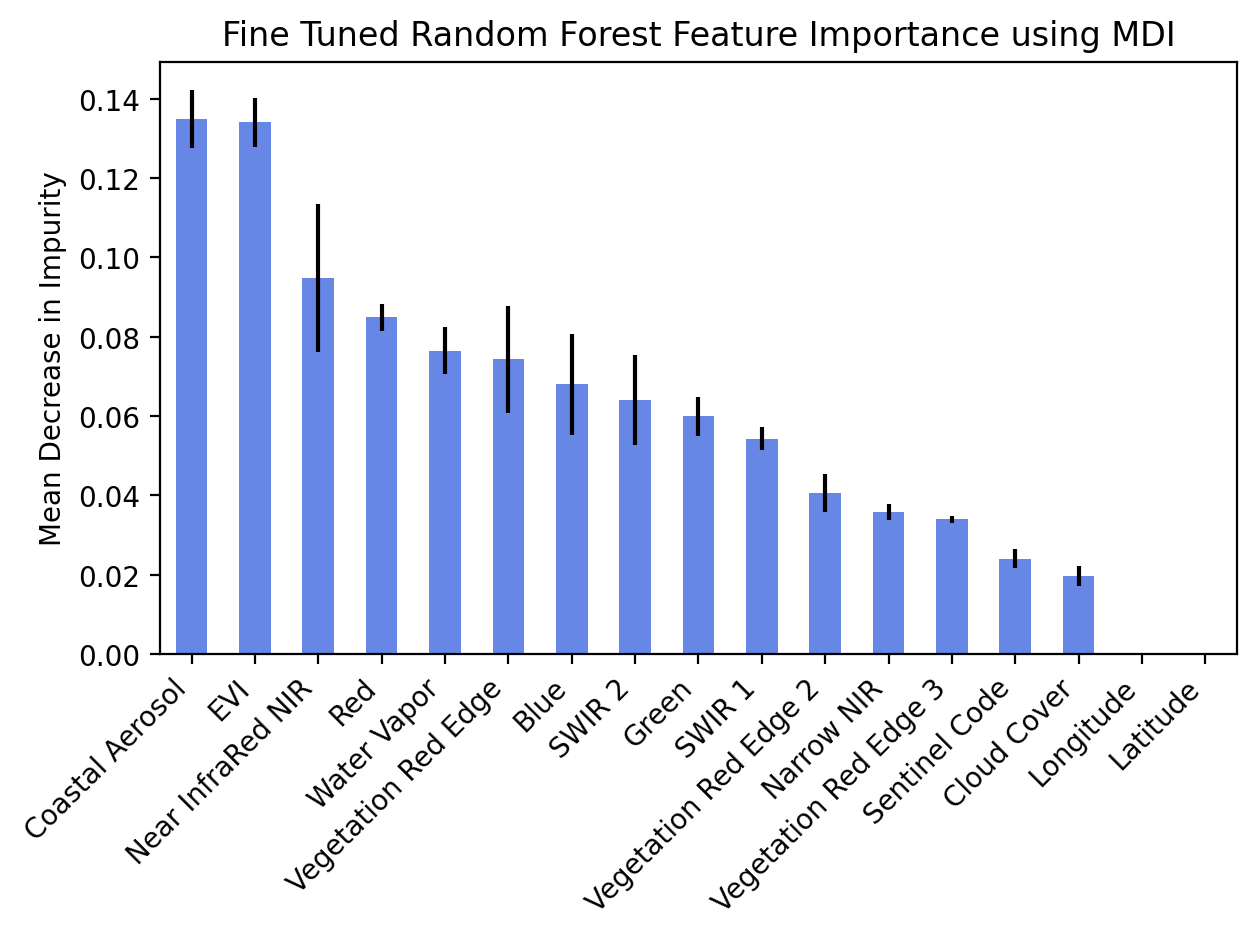

In [45]:
# Extract Feature Importance
importances = rf_model_evi.feature_importances_.reshape(17, -1).sum(axis=1)
x_label = ["Coastal Aerosol", "Blue", "Green", "Red", "Vegetation Red Edge", "Vegetation Red Edge 2", "Vegetation Red Edge 3",
           "Near InfraRed NIR", "Narrow NIR", "Water Vapor", "SWIR 1", "SWIR 2", "Cloud Cover", "Sentinel Code", "Latitude", "Longitude", "EVI"]
std = rf_model_evi.feature_importances_.reshape(17, -1).std(axis=1)

sorted_bar_graph(importances, x_label, std, "Fine Tuned Random Forest Feature Importance using MDI", "Mean Decrease in Impurity")


### IV. SPECTURAL BANDS

In [3]:
experiments = ["RBG", "No Coastal Aerosol", "No Blue", "No Green", "No Red", "No Vegetation Red Edge", "No Vegetation Red Edge 2", "No Vegetation Red Edge 3",
               "No Near InfraRed NIR", "No Narrow NIR", "No Water Vapor", "No SWIR 1", "No SWIR 2", "No Cloud Cover", "No Latitude", "No Longitude"]
avg_rmse_lst = []
rmse_std_lst = []
avg_r_squared_lst = []

# define a function to try different bands and environmental factors


def experiment(x_train: np.ndarray, x_test: np.ndarray) -> None:
    """Try out different experiments for biomass estimation."""

    rmse_lst = []
    r_2_lst = []

    for i in range(3):
        rf = RandomForestRegressor(
            random_state=i
        ).fit(x_train, y_train)
        rmse_lst.append(np.sqrt(mse(y_test, rf.predict(x_test))))
        r_2_lst.append(rf.score(x_test, y_test))

    # calculate standard deviation of RMSE
    std = np.std(rmse_lst)
    print(f"""
    RMSEs on Test Dataset: {rmse_lst}
    Average RMSE: {np.mean(rmse_lst):.4f}
    Standard Deviation of RMSEs: {std:.4f}
    R-Squared on Test Dataset: {r_2_lst}
    Average R-Squared: {np.mean(r_2_lst):.2%}
    """)

    avg_rmse_lst.append(np.mean(rmse_lst))
    rmse_std_lst.append(std)
    avg_r_squared_lst.append(np.mean(r_2_lst))


In [4]:
# 1. RBG
experiment(x_train_wo_evi[:, 3:12], x_test_wo_evi[:, 3:12])



    RMSEs on Test Dataset: [64.88742968028231, 65.03758275479981, 65.15883354673348]
    Average RMSE: 65.0279
    Standard Deviation of RMSEs: 0.1110
    R-Squared on Test Dataset: [0.008896428570559833, 0.004304185210301181, 0.000588135519095534]
    Average R-Squared: 0.46%
    


In [5]:
# 2. No Coastal Aerosol
experiment(x_train_wo_evi[:, 3:], x_test_wo_evi[:, 3:])



    RMSEs on Test Dataset: [64.42139029691045, 64.63817891502201, 64.54306223256957]
    Average RMSE: 64.5342
    Standard Deviation of RMSEs: 0.0887
    R-Squared on Test Dataset: [0.023082059813607003, 0.016496016435341043, 0.01938838775000007]
    Average R-Squared: 1.97%
    


In [6]:
# 3. No Blue
experiment(x_train_wo_evi[:, np.r_[0:3, 6:48]],
           x_test_wo_evi[:, np.r_[0:3, 6:48]])



    RMSEs on Test Dataset: [64.6219989185772, 64.68566128746394, 64.84576721219265]
    Average RMSE: 64.7178
    Standard Deviation of RMSEs: 0.0941
    R-Squared on Test Dataset: [0.016988329169726812, 0.015050547039110351, 0.010168741711625184]
    Average R-Squared: 1.41%
    


In [7]:
# 4. No Green
experiment(x_train_wo_evi[:, np.r_[0:6, 9:48]],
           x_test_wo_evi[:, np.r_[0:6, 9:48]])



    RMSEs on Test Dataset: [64.6735760584676, 64.57202029946156, 64.73092599038223]
    Average RMSE: 64.6588
    Standard Deviation of RMSEs: 0.0657
    R-Squared on Test Dataset: [0.015418549081629429, 0.018508262576759527, 0.013671600223484237]
    Average R-Squared: 1.59%
    


In [8]:
# 5. No Red
experiment(x_train_wo_evi[:, np.r_[0:9, 12:48]],
           x_test_wo_evi[:, np.r_[0:9, 12:48]])



    RMSEs on Test Dataset: [64.70640571411737, 64.82093107690888, 64.89335970412857]
    Average RMSE: 64.8069
    Standard Deviation of RMSEs: 0.0770
    R-Squared on Test Dataset: [0.014418707229766237, 0.010926813558111315, 0.00871526755365204]
    Average R-Squared: 1.14%
    


In [9]:
# 6. No Vegetation_Red_Edge
experiment(x_train_wo_evi[:, np.r_[0:12, 15:48]],
           x_test_wo_evi[:, np.r_[0:12, 15:48]])



    RMSEs on Test Dataset: [64.73684621327337, 64.60981392011449, 64.72091086991342]
    Average RMSE: 64.6892
    Standard Deviation of RMSEs: 0.0565
    R-Squared on Test Dataset: [0.013491174842305331, 0.017359003758088076, 0.013976784597746317]
    Average R-Squared: 1.49%
    


In [10]:
# 7. No Vegetation_Red_Edge 2
experiment(x_train_wo_evi[:, np.r_[0:15, 18:48]],
           x_test_wo_evi[:, np.r_[0:15, 18:48]])



    RMSEs on Test Dataset: [64.53660759289214, 64.58872990730488, 64.63795372310709]
    Average RMSE: 64.5878
    Standard Deviation of RMSEs: 0.0414
    R-Squared on Test Dataset: [0.019584510397750665, 0.018000226311055578, 0.01650286925091582]
    Average R-Squared: 1.80%
    


In [11]:
# 8. Vegetation_Red_Edge 3
experiment(x_train_wo_evi[:, np.r_[0:18, 21:48]],
           x_test_wo_evi[:, np.r_[0:18, 21:48]])



    RMSEs on Test Dataset: [64.57196335878629, 64.66130177794491, 64.69169896589638]
    Average RMSE: 64.6417
    Standard Deviation of RMSEs: 0.0508
    R-Squared on Test Dataset: [0.01850999356728411, 0.015792237467663228, 0.014866670566809792]
    Average R-Squared: 1.64%
    


In [12]:
# 9. No NIR
experiment(x_train_wo_evi[:, np.r_[0:21, 24:48]],
           x_test_wo_evi[:, np.r_[0:21, 24:48]])



    RMSEs on Test Dataset: [64.90050516073748, 64.60511034100509, 64.81157584182807]
    Average RMSE: 64.7724
    Standard Deviation of RMSEs: 0.1237
    R-Squared on Test Dataset: [0.00849695332112288, 0.017502070612606002, 0.011212287533888698]
    Average R-Squared: 1.24%
    


In [13]:
# 10. No Narrow NIR
experiment(x_train_wo_evi[:, np.r_[0:24, 27:48]],
           x_test_wo_evi[:, np.r_[0:24, 27:48]])



    RMSEs on Test Dataset: [64.54222465236496, 64.6767195149166, 64.42137834376935]
    Average RMSE: 64.5468
    Standard Deviation of RMSEs: 0.1043
    R-Squared on Test Dataset: [0.019413838527112648, 0.01532283567544479, 0.023082422340303332]
    Average R-Squared: 1.93%
    


In [14]:
# 11. No water vapor
experiment(x_train_wo_evi[:, np.r_[0:27, 30:48]],
           x_test_wo_evi[:, np.r_[0:27, 30:48]])



    RMSEs on Test Dataset: [64.50994314088787, 64.41970012984468, 64.45707049057006]
    Average RMSE: 64.4622
    Standard Deviation of RMSEs: 0.0370
    R-Squared on Test Dataset: [0.02039449537138216, 0.02313332020587444, 0.021999615801934325]
    Average R-Squared: 2.18%
    


In [15]:
# 12. no SWIR1
experiment(x_train_wo_evi[:, np.r_[0:30, 33:48]],
           x_test_wo_evi[:, np.r_[0:30, 33:48]])



    RMSEs on Test Dataset: [64.75155624002157, 64.75348769122753, 64.60453577743631]
    Average RMSE: 64.7032
    Standard Deviation of RMSEs: 0.0698
    R-Squared on Test Dataset: [0.013042798970686942, 0.01298391889992323, 0.01751954616534268]
    Average R-Squared: 1.45%
    


In [16]:
# 13. no SWIR2
experiment(x_train_wo_evi[:, np.r_[0:33, 36:48]],
           x_test_wo_evi[:, np.r_[0:33, 36:48]])



    RMSEs on Test Dataset: [64.82258341232645, 64.50841606834068, 64.61073288206359]
    Average RMSE: 64.6472
    Standard Deviation of RMSEs: 0.1308
    R-Squared on Test Dataset: [0.010876388442059959, 0.020440873058127362, 0.017331050849628604]
    Average R-Squared: 1.62%
    


### IV. Environmental factors


In [17]:
# 1. no Cloud
experiment(x_train_wo_evi[:, np.r_[0:36, 39:48]],
           x_test_wo_evi[:, np.r_[0:36, 39:48]])



    RMSEs on Test Dataset: [64.7129342043316, 64.67373595497806, 64.59187669188155]
    Average RMSE: 64.6595
    Standard Deviation of RMSEs: 0.0504
    R-Squared on Test Dataset: [0.014219818654568117, 0.015413680591514378, 0.01790453726366459]
    Average R-Squared: 1.58%
    


In [18]:
# 2. no Latitude
experiment(x_train_wo_evi[:, np.r_[0:42, 45:48]],
           x_test_wo_evi[:, np.r_[0:42, 45:48]])



    RMSEs on Test Dataset: [64.83300589596647, 64.59299176399819, 64.68401321765323]
    Average RMSE: 64.7033
    Standard Deviation of RMSEs: 0.0989
    R-Squared on Test Dataset: [0.010558290862735853, 0.0178706284573239, 0.015100735743911686]
    Average R-Squared: 1.45%
    


In [19]:
# 3. no Longitude
experiment(x_train_wo_evi[:, :45], x_test_wo_evi[:, :45])



    RMSEs on Test Dataset: [64.83300589596647, 64.59299176399819, 64.68401321765323]
    Average RMSE: 64.7033
    Standard Deviation of RMSEs: 0.0989
    R-Squared on Test Dataset: [0.010558290862735853, 0.0178706284573239, 0.015100735743911686]
    Average R-Squared: 1.45%
    


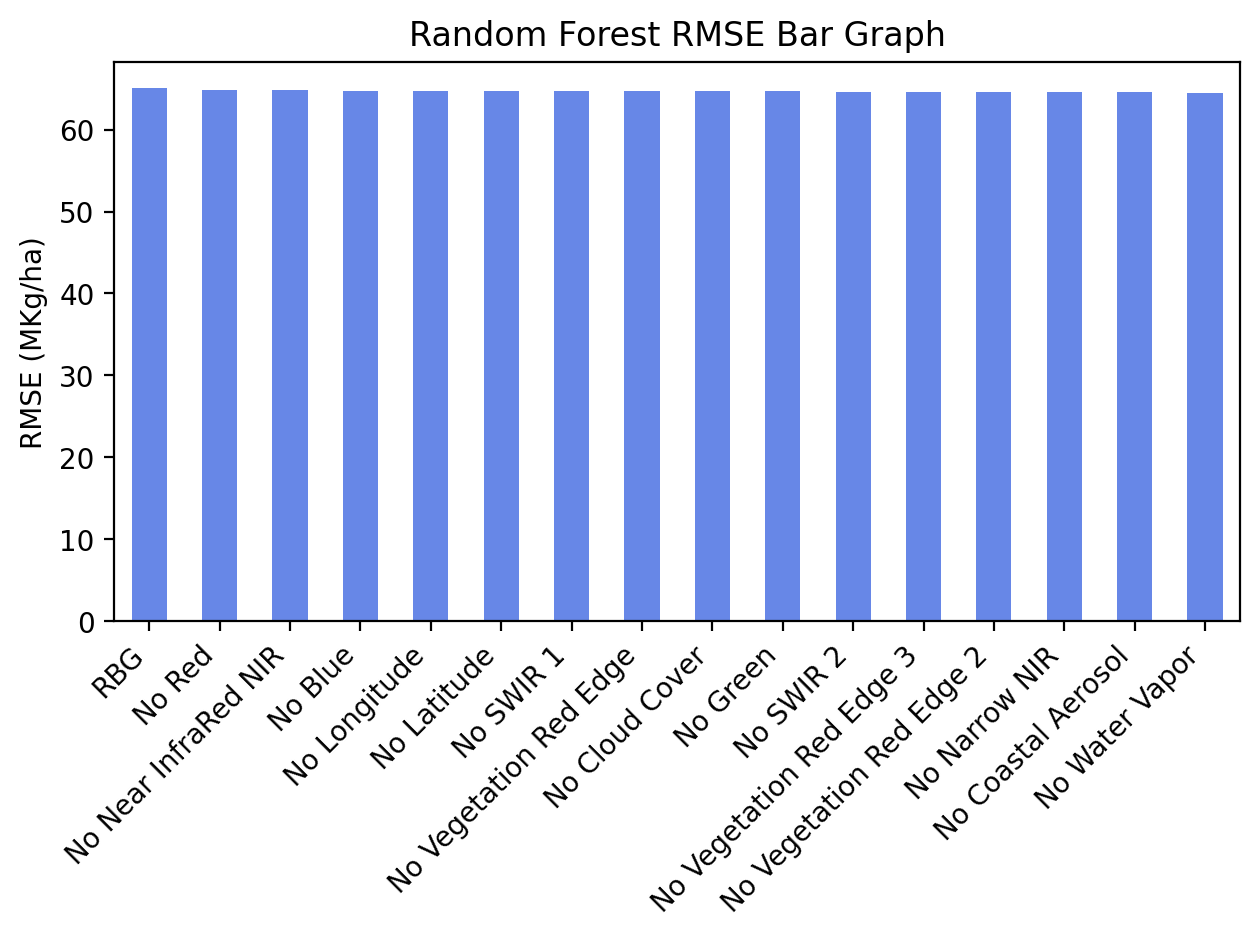

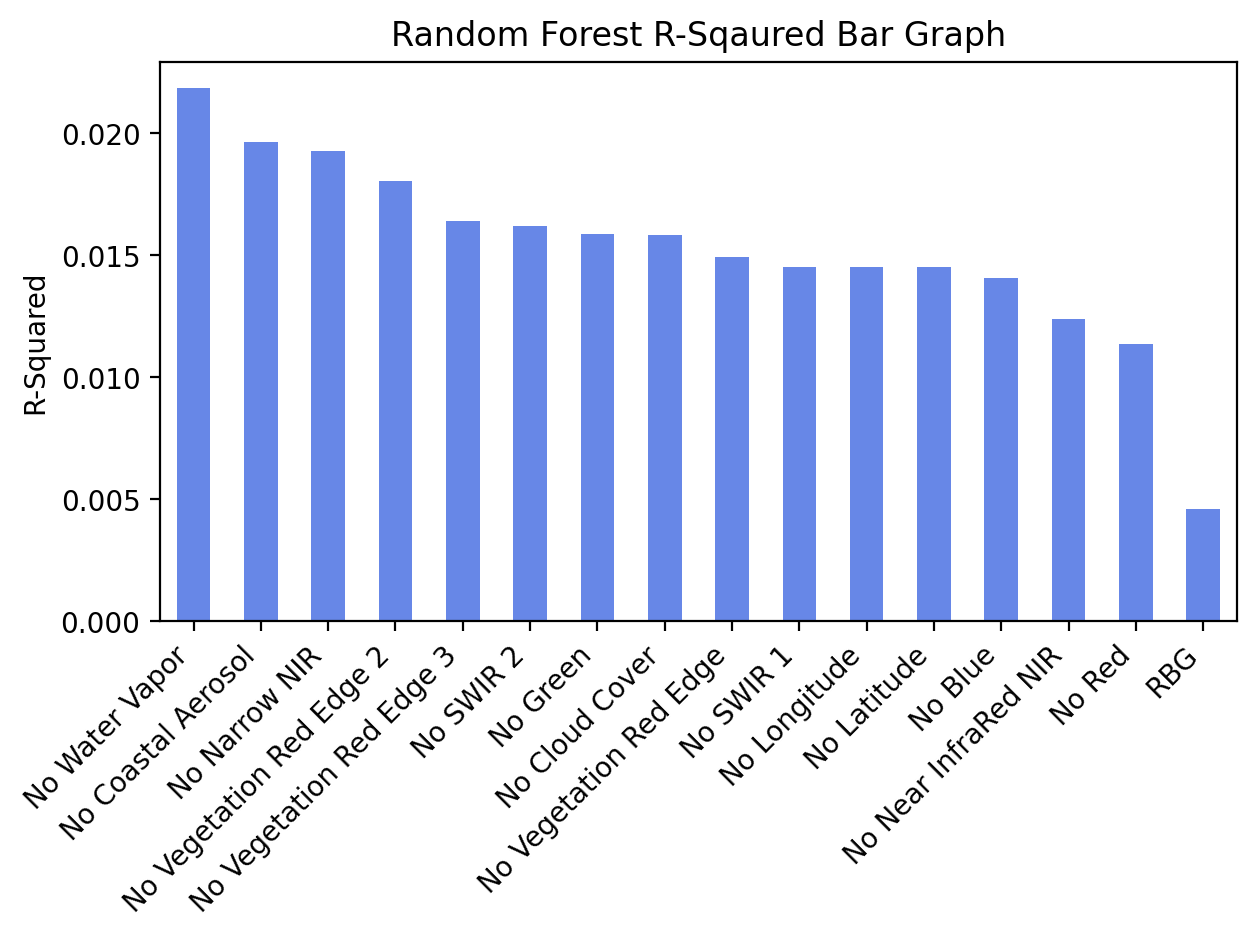

In [44]:
def sorted_bar_graph_no_sd(values: np.ndarray, x_labels: list[str], title: str, y_label: str) -> None:
    """Plot sorted bar graph with no standard deviation for RMSE and R-Squared."""
    # create tuples of importance scores and labels, sort by importance scores
    sorted_data = sorted(zip(values, x_labels), reverse=True)

    # unpack sorted importance scores and labels into separate lists
    sorted_values, sorted_x_labels = zip(*sorted_data)

    fig, ax = plt.subplots()
    forest_importances = pd.Series(sorted_values, index=sorted_x_labels)
    forest_importances.plot.bar(ax=ax, alpha=0.8, color="royalblue")
    ax.set_title(title)
    ax.set_xticks(range(len(sorted_x_labels)),
                  sorted_x_labels, rotation=45, ha="right")
    ax.set_ylabel(y_label)
    fig.tight_layout()
    plt.show()


sorted_bar_graph_no_sd(avg_rmse_lst, experiments,
                       "Random Forest RMSE Bar Graph", "RMSE (MKg/ha)")
sorted_bar_graph_no_sd(avg_r_squared_lst, experiments,
                       "Random Forest R-Sqaured Bar Graph", "R-Squared")
